# Goal

* map-reduce langgraph

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field


In [3]:
model = ChatOpenAI(model="gpt-4o-mini")

In [4]:
# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 4 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
rating_prompt = """Generate rating from 1 (bad) to 10 (great) for the following joke: {joke}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""

In [111]:
class Subjects(BaseModel):
    subjects: list[str]

class Joke(BaseModel):
    joke: str

class Rating(BaseModel):
    rating: int

class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)


In [219]:
# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    ratings: Annotated[list, operator.add]
    best_selected_joke: str

# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: Annotated[list, operator.add]
    joke: Annotated[list, operator.add]
    rating: Annotated[list, operator.add]

In [230]:
# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"][0])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"joke": [response.joke]}

# Here we generate a review of the joke
def generate_rating(state: JokeState):
    prompt = rating_prompt.format(joke=state["joke"][0])
    response = model.with_structured_output(Rating).invoke(prompt)
    return {"rating": [response.rating]}

# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes_and_ratings(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke_and_rating", {"subject": [s]}) for s in state["subjects"]]

def update_overall_state(joke_state: JokeState, state: OverallState):
    # Append the joke and rating to the respective lists in OverallState
    #state["jokes"] += joke_state["joke"]
    #state["ratings"] += joke_state["rating"]
    #return state
    return {
        "jokes": joke_state["joke"],
        "ratings": joke_state["rating"]
    }

# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

In [231]:
#-- sub graph --#
## nodes
sub_graph = StateGraph(JokeState)
sub_graph.add_node("generate_joke", generate_joke)
sub_graph.add_node("generate_rating", generate_rating)

## edges
sub_graph.add_edge(START, "generate_joke")
sub_graph.add_edge("generate_joke", "generate_rating")

#-- main graph --#
graph = StateGraph(OverallState)

## nodes
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke_and_rating", sub_graph.compile())
graph.add_node("update_overall_state", update_overall_state)
graph.add_node("best_joke", best_joke)

## edges
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes_and_ratings, ["generate_joke_and_rating"])
graph.add_edge("generate_joke_and_rating", "update_overall_state")
#graph.add_edge("update_overall_state", END)
graph.add_edge("update_overall_state", "best_joke")
graph.add_edge("best_joke", END)

#-- compile the graph --#
app = graph.compile()

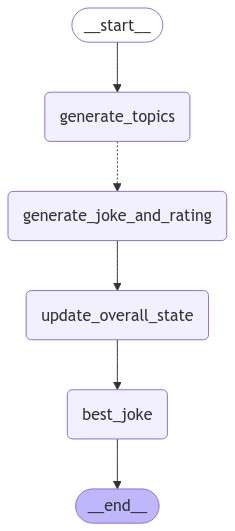

In [232]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

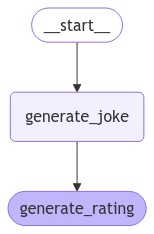

In [233]:
from IPython.display import Image

Image(sub_graph.compile().get_graph().draw_mermaid_png())

In [234]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}, subgraphs=True, config={"max_concurrency" : 3}):
    print(s)

((), {'generate_topics': {'subjects': ['cats', 'dogs', 'elephants', 'dolphins']}})
(('generate_joke_and_rating:4ac2c887-8ef2-5149-36d4-11685f8e6f48',), {'generate_joke': {'joke': ["Why did the dog sit in the shade? Because he didn't want to become a hot dog!"]}})
(('generate_joke_and_rating:4fe0f85a-ab70-8399-0827-a88dce2af2a0',), {'generate_joke': {'joke': ['Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse!']}})
(('generate_joke_and_rating:4ac2c887-8ef2-5149-36d4-11685f8e6f48',), {'generate_rating': {'rating': [6]}})
((), {'generate_joke_and_rating': {'subject': ['dogs'], 'joke': ["Why did the dog sit in the shade? Because he didn't want to become a hot dog!"], 'rating': [6]}})
(('generate_joke_and_rating:8d93b26d-130f-0430-fcdd-4e7ce9f992fb',), {'generate_joke': {'joke': ["Why don't elephants use computers? Because they're afraid of the mouse!"]}})
(('generate_joke_and_rating:4fe0f85a-ab70-8399-0827-a88dce2af2a0',), {'generate_rating': {'rating': [7]

TypeError: update_overall_state() missing 1 required positional argument: 'state'